# 간단한 이미지 분류기

안녕하세요. 이번 시간에는 이미지를 분류하는 간단한 인공지능을 만들어 볼 예정입니다. 이번 코스를 진행하고 나면, 여러분들은 숫자 손글씨를 인식할 수도 있고요. 가위바위보 게임을 만들어볼 수도 있습니다. 숫자는 0~9까지 총 10개의 클래스(class)만 인식을 하면 되고, 가위바위보는 총 3개의 클래스만 구분을 해내면 되죠. 이렇게 클래스가 몇 개 안되는 경우, 인공지능은 간단하게 이미지를 분류해 낼 수 있습니다.

# 어떻게 만들지?
일반적으로 딥러닝 기술은 **"데이터 준비 → 딥러닝 네트워크 설계 → 학습 → 테스트(평가)"** 의 순서대로 만들게 됩니다. 우리도 이 과정을 따를 거예요.

숫자 손글씨 분류기는 손으로 쓴 숫자 이미지를 입력으로 받으면, 그 이미지가 어떤 숫자를 나타내는지 출력해 낼 수 있습니다. 위 그림에서 보면, 숫자 0에 해당하는 이미지가 입력으로 들어오면 숫자 0을 출력으로, 숫자 5에 해당하는 이미지가 입력으로 들어오면 숫자 5를 출력으로 내보내고 있습니다. 우리는 딥러닝 기술을 이용해서 이런 숫자 손글씨 분류기를 만들 거예요.

# 데이터 준비
## MNIST 숫자 손글씨 Dataset 불러들이기
오늘은 텐서플로우(TensorFlow)의 표준 API인 tf.keras의 Sequential API를 이용하여 숫자 손글씨 인식기를 만들 거예요. 구글(Google)에서 오픈소스로 제공하는 텐서플로우는 가장 널리 사용되고 있는 머신러닝 라이브러리 중 하나입니다. 앞으로 딥러닝 구현 실습은 Tensorflow 버전 2.4.1에서 진행될 예정입니다.

자, 그럼 TF 2.4.1이 설치된 환경에서 먼저 다음의 코드를 실행해 봅시다. 앞으로 보게 될 코드의 구체적인 의미와 메커니즘은 이후에 더 자세하게 배우게 될 테니, 지금은 완벽하게 이해하지 못하더라도 마음 편하게 실행해 보세요.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os


print(tf.__version__)   # Tensorflow의 버전을 출력

mnist = keras.datasets.mnist

# MNIST 데이터를 로드. 다운로드하지 않았다면 다운로드까지 자동으로 진행됩니다. 
(x_train, y_train), (x_test, y_test) = mnist.load_data()   

print(len(x_train))  # x_train 배열의 크기를 출력

2.6.0
11501568/11490434 [==============================] - 0s 0us/step
60000


자, 한번 불러들인 숫자 손글씨 이미지 하나를 출력해볼까요? MNIST 데이터셋의 X항목(위 코드에서는 x_train, x_test)은 이미지 데이터를 담은 행렬(matrix)입니다.

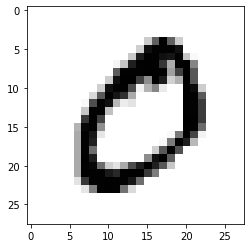

In [2]:
plt.imshow(x_train[1],cmap=plt.cm.binary)
plt.show()

숫자 0 이미지가 나왔나요? 주의할 것은, x_train[1]에 담긴 이미지는 x_train 행렬의 1번째가 아니라 2번째 이미지라는 점입니다. 1번째 이미지는 x_train[0]에 담겨 있습니다.

그렇다면 Y항목에는 어떤 값이 들어 있을까요? y_train 행렬의 2번째 값을 확인해 봅시다.

In [3]:
print(y_train[1])

0


네, Y항목(위 코드의 y_train, y_test)에는 X항목에 들어있는 이미지에 대응하는 실제 숫자 값이 담겨 있는 것을 확인하실 수 있습니다.

그럼 이번에는 또 다른 이미지를 출력해볼까요?

363


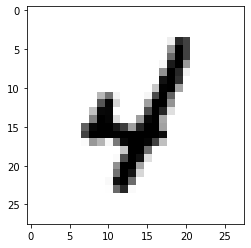

364 번째 이미지의 숫자는 바로  4 입니다.


In [6]:
# index에 0에서 59999 사이 숫자를 지정해 보세요.
index=int(input())     
plt.imshow(x_train[index],cmap=plt.cm.binary)
plt.show()
print( (index+1), '번째 이미지의 숫자는 바로 ',  y_train[index], '입니다.')

## 학습용 데이터와 시험용 데이터
위 코드를 다시 살펴봅시다.

> (x_train, y_train), (x_test, y_test) = mnist.load_data()

mnist.load( ) 함수를 통해 학습용 데이터 (x_train, y_train)와 시험용 데이터 (x_test, y_test)를 나누어서 받아들이는 것을 볼 수 있는데요.

우리가 만든 숫자 손글씨 분류기는 학습용 데이터 (x_train, y_train)만을 가지고 학습시킵니다. 학습이 끝난 후에는 이 손글씨 분류기가 얼마나 좋은 성능을 보이는지 확인해보고 싶을 텐데요, 이 때 시험용 데이터(x_test,y_test)로 테스트를 할 수 있습니다.

MNIST 데이터셋은 약 500명 사용자가 작성한 숫자 이미지를 가지고 있습니다. 그 중 250여명의 데이터가 학습용 데이터로, 다른 250여명의 데이터가 시험용 데이터로 이용됩니다.

# 데이터 전처리 하기
숫자 손글씨 이미지의 실제 픽셀 값은 0과 255 사이의 값을 가집니다. 
한번 확인해 볼까요?
인공지능 모델을 훈련시키고 사용할 때, 
일반적으로 입력은 0과 1 사이의 값으로 정규화 시켜주는 것이 좋습니다. MNIST 데이터는 각 픽셀의 값이 0~255 사이 범위에 있으므로 데이터들을 255.0 으로 나누어주면 됩니다. 최소값이 0, 최대값이 1에 근접하도록 나오는지 확인해 봅시다.

In [8]:
print('최소값:',np.min(x_train), ' 최대값:',np.max(x_train))

x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0

print('최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm))

최소값: 0  최대값: 255
최소값: 0.0  최대값: 1.0


# 딥러닝 네트워크 설계
## Sequential Model을 사용해 보자
데이터가 모두 준비가 되었다면 이제는 딥러닝 네트워크를 만들어야 합니다. 이번 수업에서는 텐서플로우 케라스(tf.keras)에서 Sequential API라는 방법을 사용할 겁니다. Sequential API는 개발의 자유도는 많이 떨어지지만, 매우 간단하게 딥러닝 모델을 만들어낼 수 있는 방법입니다. 여러분들은 이 방법을 통해 미리 정의된 딥러닝 레이어(layer)를 손쉽게 추가할 수 있습니다.

케라스에서 모델을 만드는 방법은 Sequential API 외에도 Functional API를 이용하는 방법, 밑바닥부터 직접 코딩하는 방법 등 여러 방법이 있습니다. 공부하면서 하나씩 배워나갈 테니 걱정 마세요 :)

이번 수업의 목적은 여러분들에게 딥러닝 네트워크의 모든 것을 가르치는 것이 아닙니다. 빠르게 다양한 응용 예들을 접해보고, 주어진 코드를 다른 데이터에 활용을 해보는 경험을 전달해 드리는 것이 그 목적입니다. 따라서 코드의 내용이 당장 이해가 안 가더라도 부담가지지 않으셔도 됩니다. 최대한 이해를 하려 노력은 하되, 프로그램 수행 결과에서 재미를 느끼는 것이 무엇보다도 중요합니다.

다음의 코드는 tf.keras의 Sequential API를 이용하여 LeNet이라는 딥러닝 네트워크를 설계한 예입니다. 8줄밖에 안되는 간단한 코드이지만, 손글씨 숫자 분류기를 구현하는 데는 충분합니다.

In [9]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


이런 간단한 코드만으로도 숫자 손글씨를 인식해 낼 수 있다면, IoT 농장에서 귤이 잘 익었는지 아닌지 판단한다거나, 사진 속 인물이 웃고 있는지 무표정인지 파악을 하는 것도 어렵지 않을 겁니다. 코드의 간단한 의미는 다음과 같습니다.

* Conv2D 레이어의 첫 번째 인자는 사용하는 이미지 특징의 수입니다. 여기서는 16과 32를 사용했습니다. 가장 먼저 16개의 이미지 특징을, 그 뒤에 32개의 이미지 특징씩을 고려하겠다는 뜻입니다. 우리의 숫자 이미지는 사실 매우 단순한 형태의 이미지입니다. 만약 강아지 얼굴 사진이 입력 이미지라면 훨씬 디테일하고 복잡한 영상일 것입니다. 그럴 경우에는 이 특징 숫자를 늘려주는 것을 고려해 볼 수 있습니다.
* Dense 레이어의 첫 번째 인자는 분류기에 사용되는 뉴런의 숫자 입니다. 이 값이 클수록 보다 복잡한 분류기를 만들 수 있습니다. 10개의 숫자가 아닌 알파벳을 구분하고 싶다면, 대문자 26개, 소문자 26개로 총 52개의 클래스를 분류해 내야 합니다. 그래서 32보다 큰 64, 128 등을 고려해 볼 수 있을 것입니다.
* 마지막 Dense 레이어의 뉴런 숫자는 결과적으로 분류해 내야 하는 클래스 수로 지정하면 됩니다. 숫자 인식기에서는 10, 알파벳 인식기에서는 52가 되겠지요.

5번째 스텝인 얼마나 잘 만들었는지 확인하기에서 이 코드를 수정해 볼 것입니다. 지금은 일단 실행하는 데 초점을 맞춥시다.

우리가 만든 딥러닝 네트워크 모델을 확인해 보려면, model.summary() 메소드를 이용하면 됩니다.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

# 딥러닝 네트워크 학습시키기
우리가 만든 네트워크의 입력은 (데이터갯수, 이미지 크기 x, 이미지 크기 y, 채널수) 와 같은 형태를 가집니다. 이전 스텝에서 첫 번째 레이어에 input_shape=(28,28,1)로 지정했던 것을 기억하시나요?
그런데 print(x_train.shape) 을 해보면,(60000, 28, 28) 로 채널수에 대한 정보가 없습니다. 따라서 (60000, 28, 28, 1) 로 만들어 주어야 합니다 (여기서 채널수 1은 흑백 이미지를 의미합니다. 컬러 이미지라면 R, G, B 세 가지 값이 있기 때문에 3이겠죠?).

In [11]:
print("Before Reshape - x_train_norm shape: {}".format(x_train_norm.shape))
print("Before Reshape - x_test_norm shape: {}".format(x_test_norm.shape))

x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 1)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.
x_test_reshaped=x_test_norm.reshape( -1, 28, 28, 1)

print("After Reshape - x_train_reshaped shape: {}".format(x_train_reshaped.shape))
print("After Reshape - x_test_reshaped shape: {}".format(x_test_reshaped.shape))

Before Reshape - x_train_norm shape: (60000, 28, 28)
Before Reshape - x_test_norm shape: (10000, 28, 28)
After Reshape - x_train_reshaped shape: (60000, 28, 28, 1)
After Reshape - x_test_reshaped shape: (10000, 28, 28, 1)


그러면 이제 x_train 학습 데이터로 딥러닝 네트워크를 학습시켜 봅시다. 여기서 epochs=10 은 전체 60,000개의 데이터를 10번 반복 사용해서 학습을 시키라는 뜻입니다. 물론 model의 입력 정의에 형태를 맞춘 x_train_reshaped가 사용되어야겠죠. 자 그러면 코드를 실행해 봅시다.

In [12]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_reshaped, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 34s 3ms/step - loss: 0.1919 - accuracy: 0.9409
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0657 - accuracy: 0.9800
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0490 - accuracy: 0.9851
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0381 - accuracy: 0.9880
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0311 - accuracy: 0.9903
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0248 - accuracy: 0.9923
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0215 - accuracy: 0.9931
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0179 - accuracy: 0.9944
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0160 - accuracy: 0.9947
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.01

각 학습이 진행됨에 따라 epoch 별로 어느 정도 인식 정확도(accuracy)가 올라가는지 확인할 수 있습니다. 인식 정확도가 0.9413에서 0.9957까지 매우 높게 올라가는군요. 9 epoch정도부터는 인식률의 상승이 미미합니다. 10 epoch정도 학습을 시키면 충분할 것 같네요. (학습할 때마다 인식 정확도는 변동됩니다.)

# 얼마나 잘 만들었는지 확인
## 테스트 데이터로 성능을 확인
사실 위의 인식 정확도는 학습용 데이터(x_train)을 가지고 구한 것입니다. 즉, 연습문제를 잘푸는 인공지능을 만든 거죠. 우리가 만든 딥러닝 네트워크는 실제 시험도 잘 볼 수 있을까요?
자 그러면 시험용 데이터(x_test)를 가지고 확인해 봅시다.

In [13]:
test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

313/313 - 1s - loss: 0.0374 - accuracy: 0.9900
test_loss: 0.03737246245145798 
test_accuracy: 0.9900000095367432


결과가 어떻게 나오나요? 99.57점을 받을 줄 알았는데, 98.85로 시험점수가 소폭 하락했네요. (힉습할 때마다 test_loss, test_accuracy 도 변동됩니다.) 역시 연습문제보다 실제 시험문제가 더 어려운가 봅니다. 위 MNIST 데이터셋 참고문헌을 보시면 학습용 데이터와 시험용 데이터의 손글씨 주인이 다른 것을 알 수 있습니다. 즉, 한 번도 본 적이 없는 필체의 손글씨가 섞여 있을 가능성이 높습니다. 어찌 보면 인식률이 떨어지는 것은 어느 정도 예상 가능한 일이었습니다.

## 어떤 데이터를 잘못 추론했을까? 
model.evaluate() 대신 model.predict()를 사용하면 model이 입력값을 보고 실제로 추론한 확률분포를 출력할 수 있습니다. 우리가 만든 model이란 사실 10개의 숫자 중 어느 것일지에 대한 확률값을 출력하는 함수입니다. 이 함수의 출력값, 즉 확률값이 가장 높은 숫자가 바로 model이 추론한 숫자가 되는 거죠.

In [14]:
predicted_result = model.predict(x_test_reshaped)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [5.6882110e-11 9.8838559e-12 1.2541586e-08 2.2299300e-10 9.8694588e-13
 4.9684860e-11 8.6121201e-17 1.0000000e+00 9.0859786e-10 9.7315640e-09]
model이 추론한 가장 가능성이 높은 결과 :  7
실제 데이터의 라벨 :  7


model.predict() 결과가 [9.5208375e-15 2.8931768e-11 1.2696462e-09 2.0265421e-08 6.1321614e-11 2.9599554e-12 1.0710074e-15 1.0000000e+00 1.0549885e-11 3.8589491e-08] 와 같이 벡터 형태로 나왔나요? 이 벡터는 model이 추론한 결과가 각각 0, 1, 2, ..., 7, 8, 9일 확률을 의미합니다.

이 경우라면 model이 추론한 결과가 7일 확률이 1.00에 근접하고 있다, 즉 이 model은 입력한 이미지가 숫자 7이라는 걸 아주 확신하고 있다는 뜻이 됩니다.

정말 숫자 7인가요?

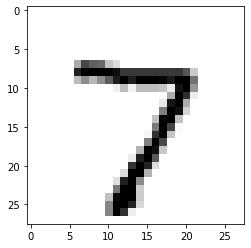

In [15]:
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

그렇다면 model이 추론해 낸 숫자와 실제 라벨의 값이 다른 경우는 어떤 경우인지 직접 확인해 볼 수도 있겠습니다.

예측확률분포: [5.0848579e-11 4.3739238e-08 4.1448462e-08 2.0892833e-01 5.6290067e-10
 6.9814625e-08 5.0981253e-14 7.9008687e-01 3.7139549e-07 9.8420959e-04]
라벨: 3, 예측결과: 7


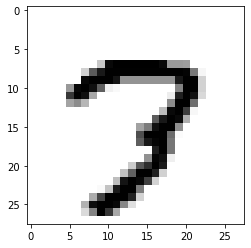

예측확률분포: [4.7298444e-13 9.1187935e-08 2.1084483e-01 4.2301473e-08 1.5962912e-15
 2.1043293e-15 1.3081262e-19 7.8915507e-01 7.3348714e-09 1.1962552e-12]
라벨: 2, 예측결과: 7


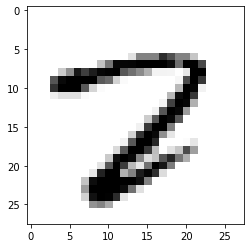

예측확률분포: [5.39095527e-05 8.07076634e-04 3.56694036e-05 2.62121489e-07
 9.60082650e-01 2.30468049e-06 4.11279267e-04 1.46829025e-05
 5.30546857e-03 3.32865901e-02]
라벨: 9, 예측결과: 4


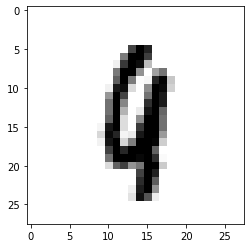

예측확률분포: [6.7985523e-01 1.0312746e-09 2.5873467e-01 6.1121393e-02 8.2864219e-12
 7.7412318e-07 7.4415816e-09 9.8243447e-10 2.8771933e-04 1.3146891e-07]
라벨: 3, 예측결과: 0


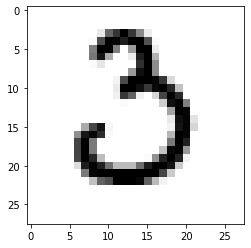

예측확률분포: [3.6001664e-09 2.6390729e-02 1.5987852e-03 1.0803413e-09 9.7003931e-01
 1.4897107e-08 9.3888908e-10 1.9677363e-03 1.1965107e-06 2.2579075e-06]
라벨: 2, 예측결과: 4


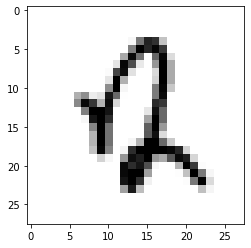

In [16]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

틀린 경우를 살펴보면 model도 추론 결과에 대한 확신도가 낮고 매우 혼란스러워 한다는 것을 알 수 있습니다. model의 추론 결과를 시각화하여 살펴보는 것은 향후 model 성능 개선에 도움이 되는 아이디어를 얻을 수 있는 좋은 방법 중 하나입니다.



# 더 좋은 네트워크 만들어 보기
그러면 인식률을 99점대로 만들 수 없을까요? 딥러닝 네트워크의 구조 자체는 바꾸지 않으면서도 우리가 해볼 수 있는 것들이 있습니다. 3번째 스텝 딥러닝 네트워크 설계하기에서 살펴본 하이퍼파라미터들을 바꾸어 보는 것인데요. Conv2D 레이어에서 입력 이미지의 특징 수를 늘리거나 줄여 보거나, Dense 레이어에서 뉴런수를 바꾸어 보거나, 학습 반복 횟수인 epoch 값을 변경해 볼 수 있을 겁니다.

In [18]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_3 (Dense)              (None, 10)               